In [1]:
import imageio
from ppo_demoenv import BipedEnv
import time
import os
import numpy as np
from stable_baselines3 import PPO, SAC
import time
import pandas as pd
import matplotlib.pyplot as plt

pybullet build time: Jan 29 2025 23:16:28


Average Speed:  1.3007177672392722
Average Speed:  1.339320513925255
Average Speed:  1.3406416703092527
Mean Speed over scenarios:  1.3268933171579267


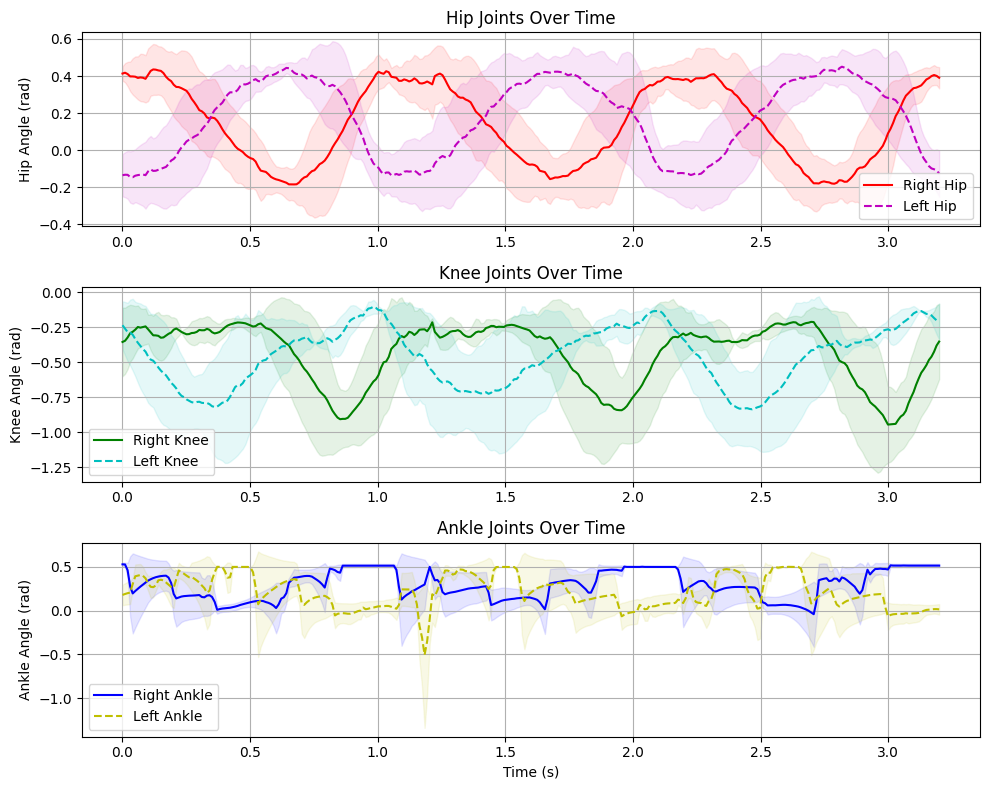

In [2]:
ppo_path = "ppo_newreward/PPO_39"
ppo_file = "final_model.zip"
ppo_type = "mlp"                # "lstm" or "mlp"

t0 = time.time()
env = BipedEnv(demo_mode=True, demo_type="joint_compare", render_mode= "None")
model = PPO.load(os.path.join(ppo_path,ppo_file),device='cpu',deterministic=True)
model.set_env(env) 


desired_speed = 1.35
angle = 0.0

total_rew = 0
success = True

dt = 1e-3 #default of pybullet
total_rew = 0

start_sec = 1.15
max_steps = int((start_sec + 4.2) * 100)
start_time = int(start_sec * 100)
end_time = int((start_sec + 3.2) * 100)
episode_start = True
lstm_states = None
obs, info = env.reset(test_speed=desired_speed, test_angle=angle, demo_max_steps=max_steps)  # Gym API
terminated = False

scenario_no = 3
rhip_posses_all = np.zeros((scenario_no,int(3.2 * 100)))
rknee_posses_all = np.zeros((scenario_no,int(3.2 * 100)))
rankle_posses_all = np.zeros((scenario_no,int(3.2 * 100)))
lhip_posses_all = np.zeros((scenario_no,int(3.2 * 100)))
lknee_posses_all = np.zeros((scenario_no,int(3.2 * 100)))
lankle_posses_all = np.zeros((scenario_no,int(3.2 * 100)))
times = np.linspace(0, 3.2, int(3.2 * 100))

speeds = []
for j in range(scenario_no):
    start_state =  True
    for i in range(0, max_steps):
        if ppo_type == "lstm":
            action, lstm_states = model.predict(obs, state=lstm_states, episode_start=episode_start)
            episode_start = False
        else:
            action, _states = model.predict(obs)
        obs, rewards, dones, truncated, info = env.step(action)
        ext_state = env.return_external_state()
        # left_swing, right_swing = env.return_left_right_swing()
        # if left_swing == True and start_state == False:
        #     start_state = True
        # # elif right_swing == True and start_state == True:
        # #     break
        if i >= start_time and i < end_time and start_state == True:
            rhip_posses_all[j,i-start_time] = obs[7] * np.pi
            rknee_posses_all[j,i-start_time] = obs[8] * np.pi
            rankle_posses_all[j,i-start_time] = obs[9] * np.pi

            lhip_posses_all[j,i-start_time] = obs[10] * np.pi
            lknee_posses_all[j,i-start_time] = obs[11] * np.pi
            lankle_posses_all[j,i-start_time] = obs[12] * np.pi

        if i== start_time:
            y_init_pos = ext_state[1]

        if i== end_time-1:
            y_final_pos = ext_state[1]
            print("Average Speed: ", (y_final_pos - y_init_pos) / 3.2)
            speeds.append((y_final_pos - y_init_pos) / 3.2)
        total_rew += rewards            
        ext_state = env.return_external_state()

        if dones:
            success = False
            terminated = True
            break
import matplotlib.pyplot as plt
import numpy as np

mean_rhip = np.mean(rhip_posses_all, axis=0)
std_rhip = np.std(rhip_posses_all, axis=0)

mean_rknee = np.mean(rknee_posses_all, axis=0)
std_rknee = np.std(rknee_posses_all, axis=0)

mean_rankle = np.mean(rankle_posses_all, axis=0)
std_rankle = np.std(rankle_posses_all, axis=0)

mean_lhip = np.mean(lhip_posses_all, axis=0)
std_lhip = np.std(lhip_posses_all, axis=0)

mean_lknee = np.mean(lknee_posses_all, axis=0)
std_lknee = np.std(lknee_posses_all, axis=0)

mean_lankle = np.mean(lankle_posses_all, axis=0)
std_lankle = np.std(lankle_posses_all, axis=0)

print("Mean Speed over scenarios: ", np.mean(speeds))

plt.figure(figsize=(10, 8))

# --- Hip subplot ---
plt.subplot(3, 1, 1)
plt.plot(times, mean_rhip, label='Right Hip', color='r')
plt.plot(times, mean_lhip, label='Left Hip', color='m', linestyle='--')
plt.fill_between(times, mean_rhip - std_rhip, mean_rhip + std_rhip, color='r', alpha=0.1)
plt.fill_between(times, mean_lhip - std_lhip, mean_lhip + std_lhip, color='m', alpha=0.1)
plt.ylabel('Hip Angle (rad)')
plt.title('Hip Joints Over Time')
plt.legend()
plt.grid()

# --- Knee subplot ---
plt.subplot(3, 1, 2)
plt.plot(times, mean_rknee, label='Right Knee', color='g')
plt.plot(times, mean_lknee, label='Left Knee', color='c', linestyle='--')
plt.fill_between(times, mean_rknee - std_rknee, mean_rknee + std_rknee, color='g', alpha=0.1)
plt.fill_between(times, mean_lknee - std_lknee, mean_lknee + std_lknee, color='c', alpha=0.1)
plt.ylabel('Knee Angle (rad)')
plt.title('Knee Joints Over Time')
plt.legend()
plt.grid()

# --- Ankle subplot ---
plt.subplot(3, 1, 3)
plt.plot(times, mean_rankle, label='Right Ankle', color='b')
plt.plot(times, mean_lankle, label='Left Ankle', color='y', linestyle='--')
plt.fill_between(times, mean_rankle - std_rankle, mean_rankle + std_rankle, color='b', alpha=0.1)
plt.fill_between(times, mean_lankle - std_lankle, mean_lankle + std_lankle, color='y', alpha=0.1)
plt.xlabel('Time (s)')
plt.ylabel('Ankle Angle (rad)')
plt.title('Ankle Joints Over Time')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


Average Speed:  1.1753754336325954
Average Speed:  1.2073537266782457
Average Speed:  1.1812710659782744
Mean Speed over scenarios:  1.188000075429705


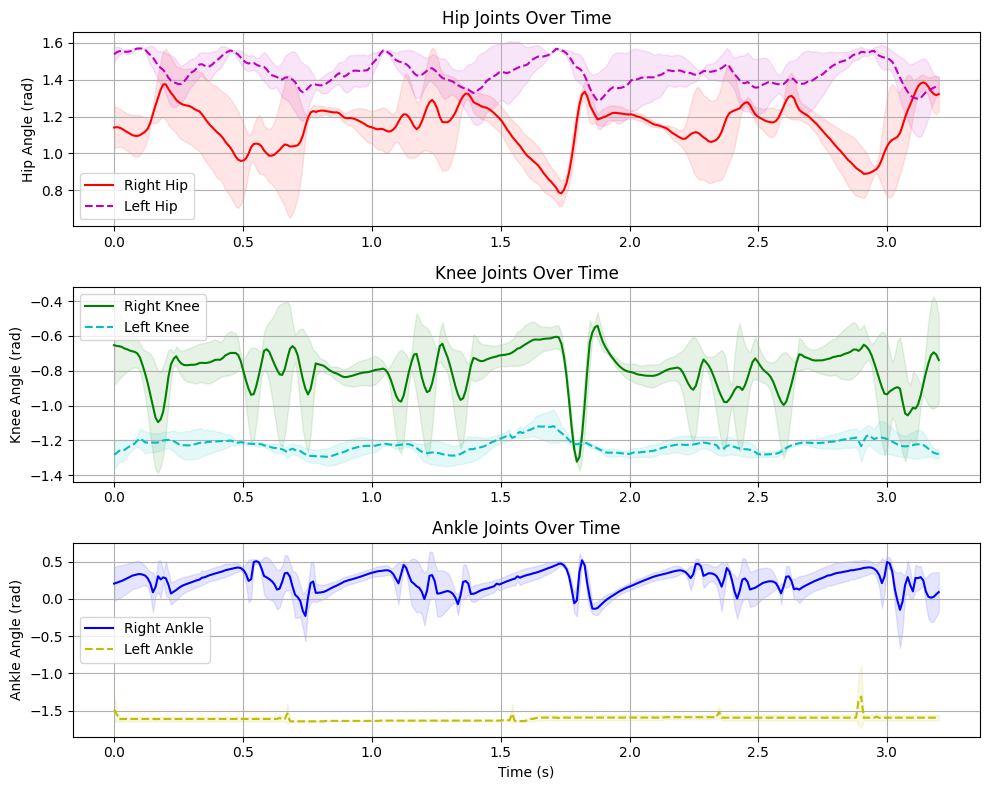

In [3]:
ppo_path = "ppo_newreward/PPO_45"
ppo_file = "final_model.zip"
ppo_type = "mlp"                # "lstm" or "mlp"

t0 = time.time()
env = BipedEnv(demo_mode=True, demo_type="joint_compare", render_mode= "None")
model = PPO.load(os.path.join(ppo_path,ppo_file),device='cpu',deterministic=True)
model.set_env(env) 


desired_speed = 1.21
angle = 0.0

total_rew = 0
success = True

dt = 1e-3 #default of pybullet
total_rew = 0

start_sec = 0.1
max_steps = int((start_sec + 4.2) * 100)
start_time = int(start_sec * 100)
end_time = int((start_sec + 3.2) * 100)
episode_start = True
lstm_states = None
obs, info = env.reset(test_speed=desired_speed, test_angle=angle, demo_max_steps=max_steps)  # Gym API
terminated = False

scenario_no = 3
rhip_posses_norew = np.zeros((scenario_no,int(3.2 * 100)))
rknee_posses_norew = np.zeros((scenario_no,int(3.2 * 100)))
rankle_posses_norew = np.zeros((scenario_no,int(3.2 * 100)))
lhip_posses_norew = np.zeros((scenario_no,int(3.2 * 100)))
lknee_posses_norew = np.zeros((scenario_no,int(3.2 * 100)))
lankle_posses_norew = np.zeros((scenario_no,int(3.2 * 100)))
times = np.linspace(0, 3.2, int(3.2 * 100))

speeds = []
for j in range(scenario_no):
    start_state =  True
    for i in range(0, max_steps):
        if ppo_type == "lstm":
            action, lstm_states = model.predict(obs, state=lstm_states, episode_start=episode_start)
            episode_start = False
        else:
            action, _states = model.predict(obs)
        obs, rewards, dones, truncated, info = env.step(action)
        ext_state = env.return_external_state()
        # left_swing, right_swing = env.return_left_right_swing()
        # if left_swing == True and start_state == False:
        #     start_state = True
        # # elif right_swing == True and start_state == True:
        # #     break
        if i >= start_time and i < end_time and start_state == True:
            rhip_posses_norew[j,i-start_time] = obs[7] * np.pi
            rknee_posses_norew[j,i-start_time] = obs[8] * np.pi
            rankle_posses_norew[j,i-start_time] = obs[9] * np.pi

            lhip_posses_norew[j,i-start_time] = obs[10] * np.pi
            lknee_posses_norew[j,i-start_time] = obs[11] * np.pi
            lankle_posses_norew[j,i-start_time] = obs[12] * np.pi

        if i== start_time:
            y_init_pos = ext_state[1]

        if i== end_time-1:
            y_final_pos = ext_state[1]
            print("Average Speed: ", (y_final_pos - y_init_pos) / 3.2)
            speeds.append((y_final_pos - y_init_pos) / 3.2)
        total_rew += rewards            
        ext_state = env.return_external_state()

        if dones:
            success = False
            terminated = True
            break
import matplotlib.pyplot as plt
import numpy as np

mean_rhip_norew = np.mean(rhip_posses_norew, axis=0)
std_rhip_norew = np.std(rhip_posses_norew, axis=0)

mean_rknee_norew = np.mean(rknee_posses_norew, axis=0)
std_rknee_norew = np.std(rknee_posses_norew, axis=0)

mean_rankle_norew = np.mean(rankle_posses_norew, axis=0)
std_rankle_norew = np.std(rankle_posses_norew, axis=0)

mean_lhip_norew = np.mean(lhip_posses_norew, axis=0)
std_lhip_norew = np.std(lhip_posses_norew, axis=0)

mean_lknee_norew = np.mean(lknee_posses_norew, axis=0)
std_lknee_norew = np.std(lknee_posses_norew, axis=0)

mean_lankle_norew = np.mean(lankle_posses_norew, axis=0)
std_lankle_norew = np.std(lankle_posses_norew, axis=0)

print("Mean Speed over scenarios: ", np.mean(speeds))

plt.figure(figsize=(10, 8))

# --- Hip subplot ---
plt.subplot(3, 1, 1)
plt.plot(times, mean_rhip_norew, label='Right Hip', color='r')
plt.plot(times, mean_lhip_norew, label='Left Hip', color='m', linestyle='--')
plt.fill_between(times, mean_rhip_norew - std_rhip_norew, mean_rhip_norew + std_rhip_norew, color='r', alpha=0.1)
plt.fill_between(times, mean_lhip_norew - std_lhip_norew, mean_lhip_norew + std_lhip_norew, color='m', alpha=0.1)
plt.ylabel('Hip Angle (rad)')
plt.title('Hip Joints Over Time')
plt.legend()
plt.grid()

# --- Knee subplot ---
plt.subplot(3, 1, 2)
plt.plot(times, mean_rknee_norew, label='Right Knee', color='g')
plt.plot(times, mean_lknee_norew, label='Left Knee', color='c', linestyle='--')
plt.fill_between(times, mean_rknee_norew - std_rknee_norew, mean_rknee_norew + std_rknee_norew, color='g', alpha=0.1)
plt.fill_between(times, mean_lknee_norew - std_lknee_norew, mean_lknee_norew + std_lknee_norew, color='c', alpha=0.1)
plt.ylabel('Knee Angle (rad)')
plt.title('Knee Joints Over Time')
plt.legend()
plt.grid()

# --- Ankle subplot ---
plt.subplot(3, 1, 3)
plt.plot(times, mean_rankle_norew, label='Right Ankle', color='b')
plt.plot(times, mean_lankle_norew, label='Left Ankle', color='y', linestyle='--')
plt.fill_between(times, mean_rankle_norew - std_rankle_norew, mean_rankle_norew + std_rankle_norew, color='b', alpha=0.1)
plt.fill_between(times, mean_lankle_norew - std_lankle_norew, mean_lankle_norew + std_lankle_norew, color='y', alpha=0.1)
plt.xlabel('Time (s)')
plt.ylabel('Ankle Angle (rad)')
plt.title('Ankle Joints Over Time')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [10]:
from ppoenv_noimstate import BipedEnv
ppo_path = "ppo_newreward/PPO_47"
ppo_file = "model_checkpoint_24ppo_256_256.zip"
ppo_type = "mlp"                # "lstm" or "mlp"

t0 = time.time()
env = BipedEnv(demo_mode=True, demo_type="joint_compare", render_mode= "None")
model = PPO.load(os.path.join(ppo_path,ppo_file),device='cpu',deterministic=True)
model.set_env(env) 


desired_speed = 1.21
angle = 0.0

total_rew = 0
success = True

dt = 1e-3 #default of pybullet
total_rew = 0

start_sec = 0.1
max_steps = int((start_sec + 4.2) * 100)
start_time = int(start_sec * 100)
end_time = int((start_sec + 3.2) * 100)
episode_start = True
lstm_states = None
obs, info = env.reset(test_speed=desired_speed, test_angle=angle, demo_max_steps=max_steps)  # Gym API
terminated = False

scenario_no = 3
rhip_posses_nostate = np.zeros((scenario_no,int(3.2 * 100)))
rknee_posses_nostate = np.zeros((scenario_no,int(3.2 * 100)))
rankle_posses_nostate = np.zeros((scenario_no,int(3.2 * 100)))
lhip_posses_nostate = np.zeros((scenario_no,int(3.2 * 100)))
lknee_posses_nostate = np.zeros((scenario_no,int(3.2 * 100)))
lankle_posses_nostate = np.zeros((scenario_no,int(3.2 * 100)))
times = np.linspace(0, 3.2, int(3.2 * 100))

speeds = []
for j in range(scenario_no):
    start_state =  True
    for i in range(0, max_steps):
        if ppo_type == "lstm":
            action, lstm_states = model.predict(obs, state=lstm_states, episode_start=episode_start)
            episode_start = False
        else:
            action, _states = model.predict(obs)
        obs, rewards, dones, truncated, info = env.step(action)
        ext_state = env.return_external_state()
        # left_swing, right_swing = env.return_left_right_swing()
        # if left_swing == True and start_state == False:
        #     start_state = True
        # # elif right_swing == True and start_state == True:
        # #     break
        if i >= start_time and i < end_time and start_state == True:
            rhip_posses_nostate[j,i-start_time] = obs[7] * np.pi
            rknee_posses_nostate[j,i-start_time] = obs[8] * np.pi
            rankle_posses_nostate[j,i-start_time] = obs[9] * np.pi

            lhip_posses_nostate[j,i-start_time] = obs[10] * np.pi
            lknee_posses_nostate[j,i-start_time] = obs[11] * np.pi
            lankle_posses_nostate[j,i-start_time] = obs[12] * np.pi

        if i== start_time:
            y_init_pos = ext_state[1]

        if i== end_time-1:
            y_final_pos = ext_state[1]
            print("Average Speed: ", (y_final_pos - y_init_pos) / 3.2)
            speeds.append((y_final_pos - y_init_pos) / 3.2)
        total_rew += rewards            
        ext_state = env.return_external_state()

        if dones:
            success = False
            terminated = True
            break
import matplotlib.pyplot as plt
import numpy as np

mean_rhip_nostate = np.mean(rhip_posses_nostate, axis=0)
std_rhip_nostate = np.std(rhip_posses_nostate, axis=0)

mean_rknee_nostate = np.mean(rknee_posses_nostate, axis=0)
std_rknee_nostate = np.std(rknee_posses_nostate, axis=0)

mean_rankle_nostate = np.mean(rankle_posses_nostate, axis=0)
std_rankle_nostate = np.std(rankle_posses_nostate, axis=0)

mean_lhip_nostate = np.mean(lhip_posses_nostate, axis=0)
std_lhip_nostate = np.std(lhip_posses_nostate, axis=0)

mean_lknee_nostate = np.mean(lknee_posses_nostate, axis=0)
std_lknee_nostate = np.std(lknee_posses_nostate, axis=0)

mean_lankle_nostate = np.mean(lankle_posses_nostate, axis=0)
std_lankle_nostate = np.std(lankle_posses_nostate, axis=0)

# print("Mean Speed over scenarios: ", np.mean(speeds))

# plt.figure(figsize=(10, 8))

# # --- Hip subplot ---
# plt.subplot(3, 1, 1)
# plt.plot(times, mean_rhip_norew, label='Right Hip', color='r')
# plt.plot(times, mean_lhip_norew, label='Left Hip', color='m', linestyle='--')
# plt.fill_between(times, mean_rhip_norew - std_rhip_norew, mean_rhip_norew + std_rhip_norew, color='r', alpha=0.1)
# plt.fill_between(times, mean_lhip_norew - std_lhip_norew, mean_lhip_norew + std_lhip_norew, color='m', alpha=0.1)
# plt.ylabel('Hip Angle (rad)')
# plt.title('Hip Joints Over Time')
# plt.legend()
# plt.grid()

# # --- Knee subplot ---
# plt.subplot(3, 1, 2)
# plt.plot(times, mean_rknee_norew, label='Right Knee', color='g')
# plt.plot(times, mean_lknee_norew, label='Left Knee', color='c', linestyle='--')
# plt.fill_between(times, mean_rknee_norew - std_rknee_norew, mean_rknee_norew + std_rknee_norew, color='g', alpha=0.1)
# plt.fill_between(times, mean_lknee_norew - std_lknee_norew, mean_lknee_norew + std_lknee_norew, color='c', alpha=0.1)
# plt.ylabel('Knee Angle (rad)')
# plt.title('Knee Joints Over Time')
# plt.legend()
# plt.grid()

# # --- Ankle subplot ---
# plt.subplot(3, 1, 3)
# plt.plot(times, mean_rankle_norew, label='Right Ankle', color='b')
# plt.plot(times, mean_lankle_norew, label='Left Ankle', color='y', linestyle='--')
# plt.fill_between(times, mean_rankle_norew - std_rankle_norew, mean_rankle_norew + std_rankle_norew, color='b', alpha=0.1)
# plt.fill_between(times, mean_lankle_norew - std_lankle_norew, mean_lankle_norew + std_lankle_norew, color='y', alpha=0.1)
# plt.xlabel('Time (s)')
# plt.ylabel('Ankle Angle (rad)')
# plt.title('Ankle Joints Over Time')
# plt.legend()
# plt.grid()

# plt.tight_layout()
# plt.show()

Average Speed:  1.1936774639862715
Average Speed:  1.2079395789325542
Average Speed:  1.1825896370580407


640
320


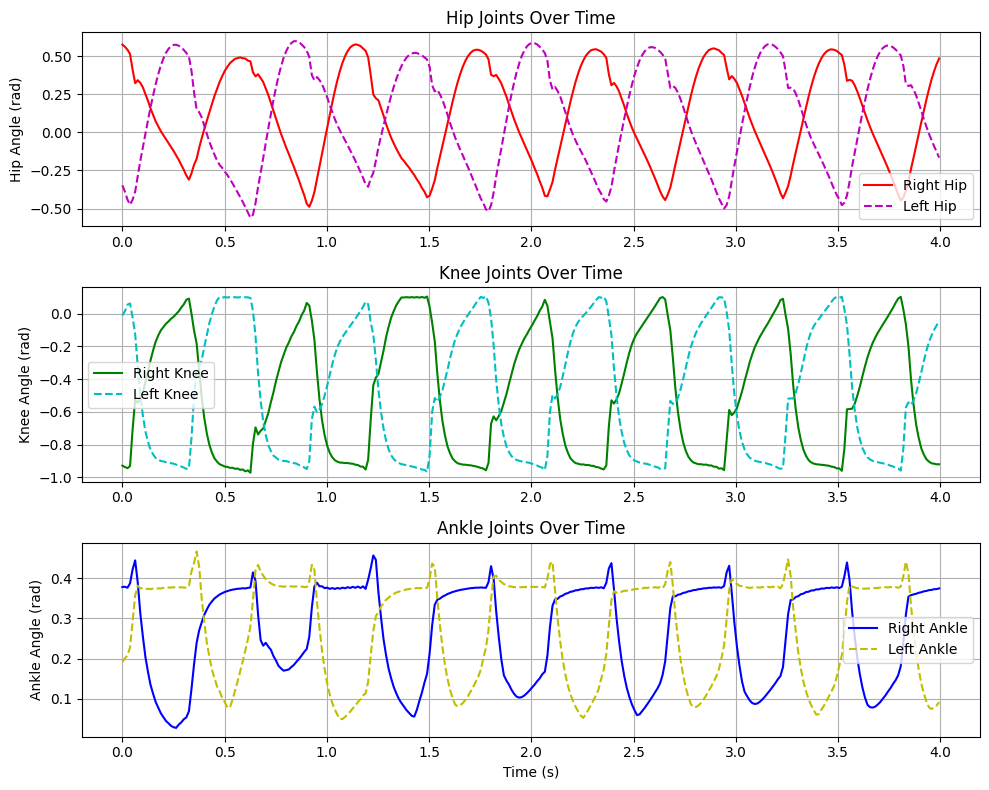

In [6]:
import sys
import matplotlib.pyplot as plt
import numpy as np
sys.path.append("locomotion-master(1)/locomotion-master")

from simbicon import run_simbicon
from scipy.signal import resample

avg_speed, ramp_angle, success, y_pos, rhip_simbicon, rknee_simbicon, rankle_simbicon, lhip_simbicon, lknee_simbicon, lankle_simbicon = run_simbicon("walk", 
    file_path="/home/baran/Bipedal-imitation-rl/locomotion-master(1)/locomotion-master/settings/cma_config_0.72.yml",sim_dt=0.0004, init_index=0,max_iters=20000, save_trajectory=False, ramp_angle=0)
times_simbicon = [i*0.0004 for i in range(len(rhip_simbicon))]


target_len = 640
rhip_simbicon = resample(rhip_simbicon, target_len)
rknee_simbicon = resample(rknee_simbicon, target_len)
rankle_simbicon = resample(rankle_simbicon, target_len)
lhip_simbicon = resample(lhip_simbicon, target_len)
lknee_simbicon = resample(lknee_simbicon, target_len)
lankle_simbicon = resample(lankle_simbicon, target_len)
times_simbicon = np.linspace(times_simbicon[0], times_simbicon[-1], target_len)

start_sec = 0.65
end_sec= 3.2 + start_sec
print(len(rhip_simbicon))
rhip_simbicon = rhip_simbicon[int((start_sec)*100):int((end_sec)*100)]
rknee_simbicon =rknee_simbicon[int((start_sec)*100):int((end_sec)*100)]
rankle_simbicon = rankle_simbicon[int((start_sec)*100):int((end_sec)*100)]

lhip_simbicon = lhip_simbicon[int((start_sec)*100):int((end_sec)*100)]
lknee_simbicon =lknee_simbicon[int((start_sec)*100):int((end_sec)*100)]
lankle_simbicon = lankle_simbicon[int((start_sec)*100):int((end_sec)*100)]

times_simbicon = times_simbicon[:int((3.2)*100)]
print(len(rhip_simbicon))

# Downsample joint arrays and time array to length 320


plt.figure(figsize=(10, 8))

# --- Hip subplot ---
plt.subplot(3, 1, 1)
plt.plot(times_simbicon, rhip_simbicon, label='Right Hip', color='r')
plt.plot(times_simbicon, lhip_simbicon, label='Left Hip', color='m', linestyle='--')
plt.ylabel('Hip Angle (rad)')
plt.title('Hip Joints Over Time')
plt.legend()
plt.grid()

# --- Knee subplot ---
plt.subplot(3, 1, 2)
plt.plot(times_simbicon, rknee_simbicon, label='Right Knee', color='g')
plt.plot(times_simbicon, lknee_simbicon, label='Left Knee', color='c', linestyle='--')
plt.ylabel('Knee Angle (rad)')
plt.title('Knee Joints Over Time')
plt.legend()
plt.grid()

# --- Ankle subplot ---
plt.subplot(3, 1, 3)
plt.plot(times_simbicon, rankle_simbicon, label='Right Ankle', color='b')
plt.plot(times_simbicon, lankle_simbicon, label='Left Ankle', color='y', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Ankle Angle (rad)')
plt.title('Ankle Joints Over Time')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()



In [7]:
# Read all saved trials in folder "1.2 human_speeds" and plot mean ± std for hip/knee/ankle
from ppo_demoenv import BipedEnv

import os
import glob
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
times = np.linspace(0, 3.2, int(3.2 * 10))

folder = "1.2 human_speeds"
files = sorted(glob.glob(os.path.join(folder, "*.npy")))
if len(files) == 0:
    print(f"No .npy files found in {folder}")
else:
    print(f"Found {len(files)} files. First few: {files[:6]}")

    trials_hip_r = []
    trials_knee_r = []
    trials_ankle_r = []
    trials_hip_l = []
    trials_knee_l = []
    trials_ankle_l = []
    lengths = []

    for fpath in files:
        try:
            arr = np.load(fpath, allow_pickle=True)
        except Exception as e:
            print(f"Failed to load {fpath}: {e}")
            continue

        # Normalize array shape to (T, C)
        if arr.ndim == 1:
            # try to infer how many channels
            if arr.size % 6 == 0:
                arr = arr.reshape(-1, 6)
            elif arr.size % 13 == 0:
                arr = arr.reshape(-1, 13)
            else:
                # fallback: treat as single-channel time series
                arr = arr.reshape(-1, 1)

        # Determine indices for joints
        C = arr.shape[1]
        # Preference: if more than 13 features use indices like obs in demo (7..12)
        if C >= 13:
            idx = {"hip_r":7, "knee_r":8, "ankle_r":9, "hip_l":10, "knee_l":11, "ankle_l":12}
        elif C >= 6:
            # assume 6 channels in order [rhip, rknee, rankle, lhip, lknee, lankle]
            idx = {"hip_r":0, "knee_r":1, "ankle_r":2, "hip_l":3, "knee_l":4, "ankle_l":5}
        else:
            print(f"File {fpath} has unexpected channel count C={C}; skipping")
            continue

        trials_hip_r.append(arr[:, idx['hip_r']])
        trials_knee_r.append(arr[:, idx['knee_r']])
        trials_ankle_r.append(arr[:, idx['ankle_r']])
        trials_hip_l.append(arr[:, idx['hip_l']])
        trials_knee_l.append(arr[:, idx['knee_l']])
        trials_ankle_l.append(arr[:, idx['ankle_l']])
        lengths.append(arr.shape[0])

    if len(lengths) == 0:
        print("No valid trials loaded.")
    else:
        max_len = max(lengths)
        # pad with NaNs to align lengths
        def pad_trials(trials):
            padded = np.full((len(trials), max_len), np.nan, dtype=float)
            for i, t in enumerate(trials):
                L = len(t)
                padded[i, :L] = t
            return padded

        hip_r_arr = pad_trials(trials_hip_r)
        knee_r_arr = pad_trials(trials_knee_r)
        ankle_r_arr = pad_trials(trials_ankle_r)
        hip_l_arr = pad_trials(trials_hip_l)
        knee_l_arr = pad_trials(trials_knee_l)
        ankle_l_arr = pad_trials(trials_ankle_l)

        # Compute mean/std across trials (ignore NaNs)
        hip_r_mean = np.nanmean(hip_r_arr, axis=0)
        hip_r_std  = np.nanstd(hip_r_arr, axis=0)
        knee_r_mean = np.nanmean(knee_r_arr, axis=0)
        knee_r_std  = np.nanstd(knee_r_arr, axis=0)
        ankle_r_mean = np.nanmean(ankle_r_arr, axis=0)
        ankle_r_std  = np.nanstd(ankle_r_arr, axis=0)

        hip_l_mean = np.nanmean(hip_l_arr, axis=0)
        hip_l_std  = np.nanstd(hip_l_arr, axis=0)
        knee_l_mean = np.nanmean(knee_l_arr, axis=0)
        knee_l_std  = np.nanstd(knee_l_arr, axis=0)
        ankle_l_mean = np.nanmean(ankle_l_arr, axis=0)
        ankle_l_std  = np.nanstd(ankle_l_arr, axis=0)

        def resample_array(arr, orig_times, target_len):
            interp_func = interp1d(orig_times, arr, kind='linear', fill_value='extrapolate')
            new_times = np.linspace(orig_times[0], orig_times[-1], target_len)
            return interp_func(new_times)


        hip_r_mean = resample_array(hip_r_mean, times, 320)
        hip_r_std = resample_array(hip_r_std, times, 320)
        knee_r_mean = resample_array(knee_r_mean, times, 320)
        knee_r_std = resample_array(knee_r_std, times, 320)
        ankle_r_mean = resample_array(ankle_r_mean, times, 320)
        ankle_r_std = resample_array(ankle_r_std, times, 320)
        hip_l_mean = resample_array(hip_l_mean, times, 320)
        hip_l_std = resample_array(hip_l_std, times, 320)
        knee_l_mean = resample_array(knee_l_mean, times, 320)
        knee_l_std = resample_array(knee_l_std, times, 320)
        ankle_l_mean = resample_array(ankle_l_mean, times, 320)
        ankle_l_std = resample_array(ankle_l_std, times, 320)
        times = np.linspace(times[0], times[-1], 320)
        # Time axis: recorded every 10 steps with dt=1e-3 -> 0.01s per sample (matches demo code)
        dt_plot = 0.01
        times = np.arange(max_len) * dt_plot

Found 8 files. First few: ['1.2 human_speeds/1.1952_speed_data.npy', '1.2 human_speeds/1.1953_speed_data.npy', '1.2 human_speeds/1.1961_speed_data.npy', '1.2 human_speeds/1.2031_speed_data.npy', '1.2 human_speeds/1.2032_speed_data.npy', '1.2 human_speeds/1.2034_speed_data.npy']


In [12]:
print(len(mean_rhip), len(mean_rhip_norew), len(rhip_simbicon), len(hip_r_mean))

320 320 320 320


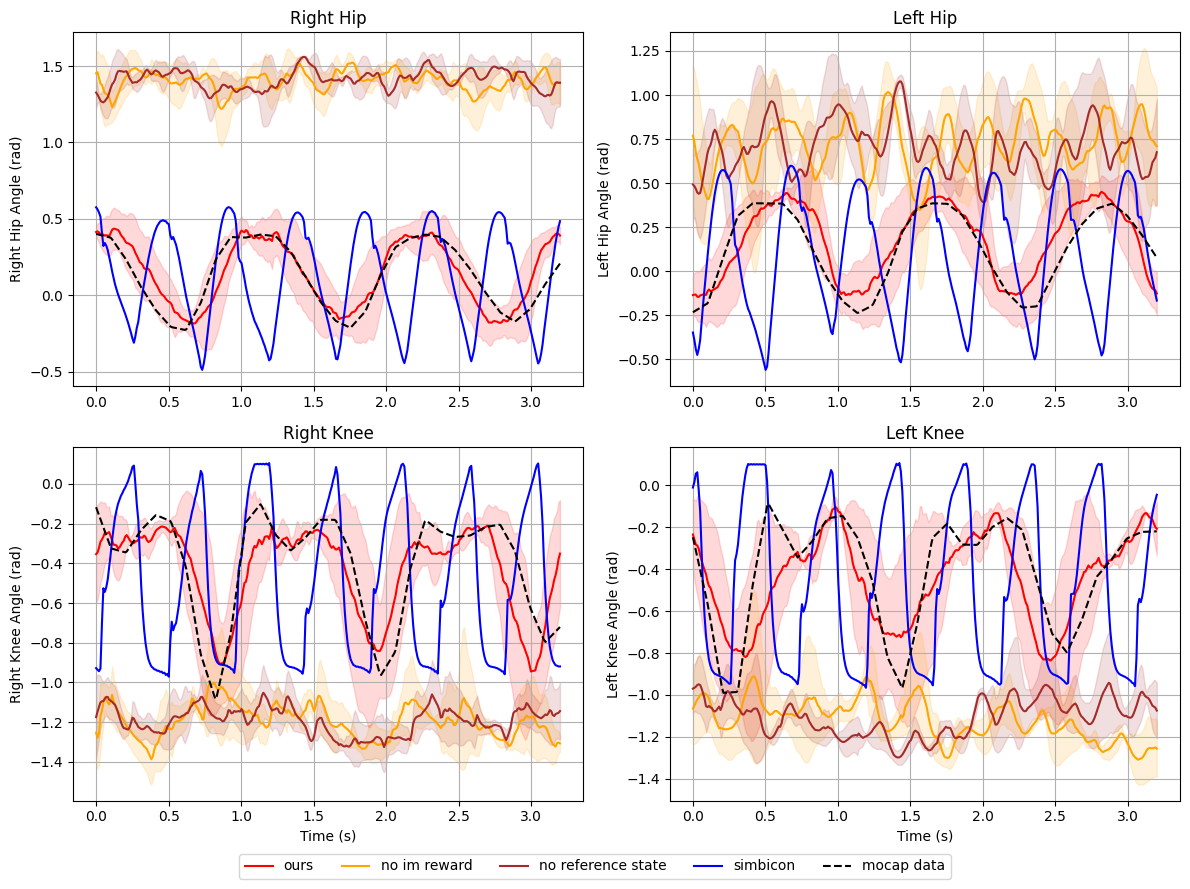

In [24]:
times = np.linspace(0, 3.2, int(3.2 * 100))
import matplotlib.pyplot as plt

# plt.figure(figsize=(16, 12))

# # --- Hip subplot ---
# ax1 = plt.subplot(2, 2, 1)
# ax1.plot(times, mean_rhip, label='ours', color='r')
# ax1.fill_between(times, mean_rhip - std_rhip, mean_rhip + std_rhip, color='r', alpha=0.15)
# ax1.plot(times, mean_rhip_norew, label='no im reward', color='orange')
# ax1.fill_between(times, mean_rhip_norew - std_rhip_norew, mean_rhip_norew + std_rhip_norew, color='orange', alpha=0.15)
# ax1.plot(times, mean_rhip_nostate, label='no reference state', color='brown')
# ax1.fill_between(times, mean_rhip_nostate - std_rhip_nostate, mean_rhip_nostate + std_rhip_nostate, color='brown', alpha=0.15)
# ax1.plot(times, rhip_simbicon, label='simbicon', color='b')
# ax1.plot(times, hip_r_mean, label='mocap data', color='k', linestyle='--')
# ax1.set_ylabel('Right Hip Angle (rad)')
# ax1.set_title('Right Hip')
# ax1.grid()

# ax2 = plt.subplot(3, 2, 2)
# ax2.plot(times, mean_lhip, color='r')
# ax2.fill_between(times, mean_lhip - std_lhip, mean_lhip + std_lhip, color='r', alpha=0.15)
# ax2.plot(times, mean_lhip_norew, color='orange')
# ax2.fill_between(times, mean_lhip_norew - std_lhip_norew, mean_lhip_norew + std_lhip_norew, color='orange', alpha=0.15)
# ax2.plot(times, mean_lhip_nostate, color='brown')
# ax2.fill_between(times, mean_lhip_nostate - std_lhip_nostate, mean_lhip_nostate + std_lhip_nostate, color='brown', alpha=0.15)
# ax2.plot(times, lhip_simbicon, color='b')
# ax2.plot(times, hip_l_mean, color='k', linestyle='--')
# ax2.set_ylabel('Left Hip Angle (rad)')
# ax2.set_title('Left Hip')
# ax2.grid()

# # --- Knee subplot ---
# ax3 = plt.subplot(3, 2, 3)
# ax3.plot(times, mean_rknee, color='g')
# ax3.fill_between(times, mean_rknee - std_rknee, mean_rknee + std_rknee, color='g', alpha=0.15)
# ax3.plot(times, mean_rknee_norew, color='lime')
# ax3.fill_between(times, mean_rknee_norew - std_rknee_norew, mean_rknee_norew + std_rknee_norew, color='lime', alpha=0.15)
# ax3.plot(times, mean_rknee_nostate, color='darkgreen')
# ax3.fill_between(times, mean_rknee_nostate - std_rknee_nostate, mean_rknee_nostate + std_rknee_nostate, color='darkgreen', alpha=0.15)
# ax3.plot(times, rknee_simbicon, color='b')
# ax3.plot(times, knee_r_mean, color='k', linestyle='--')
# ax3.set_ylabel('Right Knee Angle (rad)')
# ax3.set_title('Right Knee')
# ax3.grid()

# ax4 = plt.subplot(3, 2, 4)
# ax4.plot(times, mean_lknee, color='g')
# ax4.fill_between(times, mean_lknee - std_lknee, mean_lknee + std_lknee, color='g', alpha=0.15)
# ax4.plot(times, mean_lknee_norew, color='lime')
# ax4.fill_between(times, mean_lknee_norew - std_lknee_norew, mean_lknee_norew + std_lknee_norew, color='lime', alpha=0.15)
# ax4.plot(times, mean_lknee_nostate, color='darkgreen')
# ax4.fill_between(times, mean_lknee_nostate - std_lknee_nostate, mean_lknee_nostate + std_lknee_nostate, color='darkgreen', alpha=0.15)
# ax4.plot(times, lknee_simbicon, color='b')
# ax4.plot(times, knee_l_mean, color='k', linestyle='--')
# ax4.set_ylabel('Left Knee Angle (rad)')
# ax4.set_title('Left Knee')
# ax4.grid()

# # # --- Ankle subplot ---
# # ax5 = plt.subplot(3, 2, 5)
# # ax5.plot(times, mean_rankle, color='purple')
# # ax5.fill_between(times, mean_rankle - std_rankle, mean_rankle + std_rankle, color='purple', alpha=0.15)
# # ax5.plot(times, mean_rankle_norew, color='violet')
# # ax5.fill_between(times, mean_rankle_norew - std_rankle_norew, mean_rankle_norew + std_rankle_norew, color='violet', alpha=0.15)
# # ax5.plot(times, mean_rankle_nostate, color='indigo')
# # ax5.fill_between(times, mean_rankle_nostate - std_rankle_nostate, mean_rankle_nostate + std_rankle_nostate, color='indigo', alpha=0.15)
# # ax5.plot(times, rankle_simbicon, color='b')
# # ax5.plot(times, ankle_r_mean, color='k', linestyle='--')
# # ax5.set_xlabel('Time (s)')
# # ax5.set_ylabel('Right Ankle Angle (rad)')
# # ax5.set_title('Right Ankle')
# # ax5.grid()

# # ax6 = plt.subplot(3, 2, 6)
# # ax6.plot(times, mean_lankle, color='purple')
# # ax6.fill_between(times, mean_lankle - std_lankle, mean_lankle + std_lankle, color='purple', alpha=0.15)
# # ax6.plot(times, mean_lankle_norew, color='violet')
# # ax6.fill_between(times, mean_lankle_norew - std_lankle_norew, mean_lankle_norew + std_lankle_norew, color='violet', alpha=0.15)
# # ax6.plot(times, mean_lankle_nostate, color='indigo')
# # ax6.fill_between(times, mean_lankle_nostate - std_lankle_nostate, mean_lankle_nostate + std_lankle_nostate, color='indigo', alpha=0.15)
# # ax6.plot(times, lankle_simbicon, color='b')
# # ax6.plot(times, ankle_l_mean, color='k', linestyle='--')
# # ax6.set_xlabel('Time (s)')
# # ax6.set_ylabel('Left Ankle Angle (rad)')
# # ax6.set_title('Left Ankle')
# # ax6.grid()

# # ----- Single, global legend (pulled from ax1's labeled artists) -----
# handles, labels = ax1.get_legend_handles_labels()
# plt.figlegend(handles, labels, loc='lower center', ncol=3, frameon=True, bbox_to_anchor=(0.5, -0.01))

# # Leave room at bottom for the legend
# plt.tight_layout(rect=[0, 0.06, 1, 1])
# plt.show()


import matplotlib.pyplot as plt

plt.figure(figsize=(12, 9))  # slightly shorter height

# --- Right Hip subplot ---
ax1 = plt.subplot(2, 2, 1)
ax1.plot(times, mean_rhip, label='ours', color='r')
ax1.fill_between(times, mean_rhip - std_rhip, mean_rhip + std_rhip, color='r', alpha=0.15)
ax1.plot(times, mean_rhip_norew, label='no im reward', color='orange')
ax1.fill_between(times, mean_rhip_norew - std_rhip_norew, mean_rhip_norew + std_rhip_norew, color='orange', alpha=0.15)
ax1.plot(times, mean_rhip_nostate, label='no reference state', color='brown')
ax1.fill_between(times, mean_rhip_nostate - std_rhip_nostate, mean_rhip_nostate + std_rhip_nostate, color='brown', alpha=0.15)
ax1.plot(times, rhip_simbicon, label='simbicon', color='b')
ax1.plot(times, hip_r_mean, label='mocap data', color='k', linestyle='--')
ax1.set_ylabel('Right Hip Angle (rad)')
ax1.set_title('Right Hip')
ax1.grid()

# --- Left Hip subplot ---
ax2 = plt.subplot(2, 2, 2)
ax2.plot(times, mean_lhip, color='r')
ax2.fill_between(times, mean_lhip - std_lhip, mean_lhip + std_lhip, color='r', alpha=0.15)
ax2.plot(times, mean_lhip_norew, color='orange')
ax2.fill_between(times, mean_lhip_norew - std_lhip_norew, mean_lhip_norew + std_lhip_norew, color='orange', alpha=0.15)
ax2.plot(times, mean_lhip_nostate, color='brown')
ax2.fill_between(times, mean_lhip_nostate - std_lhip_nostate, mean_lhip_nostate + std_lhip_nostate, color='brown', alpha=0.15)
ax2.plot(times, lhip_simbicon, color='b')
ax2.plot(times, hip_l_mean, color='k', linestyle='--')
ax2.set_ylabel('Left Hip Angle (rad)')
ax2.set_title('Left Hip')
ax2.grid()

# --- Right Knee subplot ---
ax3 = plt.subplot(2, 2, 3)
ax3.plot(times, mean_rknee, color='r')
ax3.fill_between(times, mean_rknee - std_rknee, mean_rknee + std_rknee, color='r', alpha=0.15)
ax3.plot(times, mean_rknee_norew, color='orange')
ax3.fill_between(times, mean_rknee_norew - std_rknee_norew, mean_rknee_norew + std_rknee_norew, color='orange', alpha=0.15)
ax3.plot(times, mean_rknee_nostate, color='brown')
ax3.fill_between(times, mean_rknee_nostate - std_rknee_nostate, mean_rknee_nostate + std_rknee_nostate, color='brown', alpha=0.15)
ax3.plot(times, rknee_simbicon, color='b')
ax3.plot(times, knee_r_mean, color='k', linestyle='--')
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Right Knee Angle (rad)')
ax3.set_title('Right Knee')
ax3.grid()

# --- Left Knee subplot ---
ax4 = plt.subplot(2, 2, 4)
ax4.plot(times, mean_lknee, color='r')
ax4.fill_between(times, mean_lknee - std_lknee, mean_lknee + std_lknee, color='r', alpha=0.15)
ax4.plot(times, mean_lknee_norew, color='orange')
ax4.fill_between(times, mean_lknee_norew - std_lknee_norew, mean_lknee_norew + std_lknee_norew, color='orange', alpha=0.15)
ax4.plot(times, mean_lknee_nostate, color='brown')
ax4.fill_between(times, mean_lknee_nostate - std_lknee_nostate, mean_lknee_nostate + std_lknee_nostate, color='brown', alpha=0.15)
ax4.plot(times, lknee_simbicon, color='b')
ax4.plot(times, knee_l_mean, color='k', linestyle='--')
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('Left Knee Angle (rad)')
ax4.set_title('Left Knee')
ax4.grid()

# ----- Single, global legend -----
handles, labels = ax1.get_legend_handles_labels()
plt.figlegend(handles, labels, loc='lower center', ncol=5, frameon=True, bbox_to_anchor=(0.5, 0.01))

# Leave less space at bottom (tight margins)
plt.tight_layout(rect=[0, 0.04, 1, 1])

plt.show()




In [ ]:
import os

# Ensure the folder exists
os.makedirs("joint_comparison_results", exist_ok=True)

# Save Simbicon arrays
np.save("joint_comparison_results/rhip_simbicon.npy", rhip_simbicon)
np.save("joint_comparison_results/rknee_simbicon.npy", rknee_simbicon)
np.save("joint_comparison_results/rankle_simbicon.npy", rankle_simbicon)
np.save("joint_comparison_results/lhip_simbicon.npy", lhip_simbicon)
np.save("joint_comparison_results/lknee_simbicon.npy", lknee_simbicon)
np.save("joint_comparison_results/lankle_simbicon.npy", lankle_simbicon)
np.save("joint_comparison_results/times_simbicon.npy", times_simbicon)

# Save mocap (human) mean and std arrays
np.save("joint_comparison_results/hip_r_mean_mocap.npy", hip_r_mean)
np.save("joint_comparison_results/hip_r_std_mocap.npy", hip_r_std)
np.save("joint_comparison_results/knee_r_mean_mocap.npy", knee_r_mean)
np.save("joint_comparison_results/knee_r_std_mocap.npy", knee_r_std)
np.save("joint_comparison_results/ankle_r_mean_mocap.npy", ankle_r_mean)
np.save("joint_comparison_results/ankle_r_std_mocap.npy", ankle_r_std)
np.save("joint_comparison_results/hip_l_mean_mocap.npy", hip_l_mean)
np.save("joint_comparison_results/hip_l_std_mocap.npy", hip_l_std)
np.save("joint_comparison_results/knee_l_mean_mocap.npy", knee_l_mean)
np.save("joint_comparison_results/knee_l_std_mocap.npy", knee_l_std)
np.save("joint_comparison_results/ankle_l_mean_mocap.npy", ankle_l_mean)
np.save("joint_comparison_results/ankle_l_std_mocap.npy", ankle_l_std)
np.save("joint_comparison_results/times_mocap.npy", times)

# Save "ours" solution joint mean and std arrays
np.save("joint_comparison_results/mean_rhip_ours.npy", mean_rhip)
np.save("joint_comparison_results/std_rhip_ours.npy", std_rhip)
np.save("joint_comparison_results/mean_rknee_ours.npy", mean_rknee)
np.save("joint_comparison_results/std_rknee_ours.npy", std_rknee)
np.save("joint_comparison_results/mean_rankle_ours.npy", mean_rankle)
np.save("joint_comparison_results/std_rankle_ours.npy", std_rankle)
np.save("joint_comparison_results/mean_lhip_ours.npy", mean_lhip)
np.save("joint_comparison_results/std_lhip_ours.npy", std_lhip)
np.save("joint_comparison_results/mean_lknee_ours.npy", mean_lknee)
np.save("joint_comparison_results/std_lknee_ours.npy", std_lknee)
np.save("joint_comparison_results/mean_lankle_ours.npy", mean_lankle)
np.save("joint_comparison_results/std_lankle_ours.npy", std_lankle)

# Save "noim reward" joint mean and std arrays
np.save("joint_comparison_results/mean_rhip_noimrew.npy", mean_rhip_norew)
np.save("joint_comparison_results/std_rhip_noimrew.npy", std_rhip_norew)
np.save("joint_comparison_results/mean_rknee_noimrew.npy", mean_rknee_norew)
np.save("joint_comparison_results/std_rknee_noimrew.npy", std_rknee_norew)
np.save("joint_comparison_results/mean_rankle_noimrew.npy", mean_rankle_norew)
np.save("joint_comparison_results/std_rankle_noimrew.npy", std_rankle_norew)
np.save("joint_comparison_results/mean_lhip_noimrew.npy", mean_lhip_norew)
np.save("joint_comparison_results/std_lhip_noimrew.npy", std_lhip_norew)
np.save("joint_comparison_results/mean_lknee_noimrew.npy", mean_lknee_norew)
np.save("joint_comparison_results/std_lknee_noimrew.npy", std_lknee_norew)
np.save("joint_comparison_results/mean_lankle_noimrew.npy", mean_lankle_norew)
np.save("joint_comparison_results/std_lankle_noimrew.npy", std_lankle_norew)
